In [1]:
library(ggplot2)
library(dplyr) 
library(wesanderson)
library(phyloseq)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
df = read.csv("../../data/qPCR/WB2015_qPCR_combined_data_plotting.csv")

In [2]:
df[df$Fungal_18S_Copy_._perg>1e12,]
df$Fungal_18S_Copy_._perg[df$Sample=="15S-WB-12M-2"]=df$Fungal_18S_Copy_._perg[df$Sample=="15S-WB-12M-1"]
df$Fungal_18S_Copy_._perg[df$Sample=="15S-NT-U12O-2"]=df$Fungal_18S_Copy_._perg[df$Sample=="15S-NT-U12O-1"]
# Getting rid of outlier fungal samples that do not match paired extraction

,Sample,Fungal_18S_Copy_._perg,Bacterial_16S_Copy_._perg,Sample_Name,Project_ID,Sample_ID,Site_ID,Replicate,Org_or_Min,Fwd_Primer_Barcode,⋯,temp,rh,ws,prec,ffmc,dmc,dc,isi,bui,fwi
130,15S-NT-U12O-2,1.56e+13,3.35e+09,15S-NT-U12O-2,WB15,15S-NT-U12O,15S-NT-U12,2,O,AGGCTGAA,⋯,0.00000,0.00000,0.000000,0.000000000,0.0000,0.00000,0.0000,0.00000,0.00000,0.00000
168,15S-WB-12M-2,1.54e+13,5.56e+08,15S-WB-12M-2,WB15,15S-WB-12M,15S-WB-12,2,M,TTAACGAG,⋯,21.35492,64.61668,7.832447,0.000633214,87.0791,49.36143,486.3221,4.18618,78.74215,14.92921


In [3]:
# Formatting data
df$pH = as.numeric(paste(df$pH))
df$TC_pct = as.numeric(paste(df$TC_pct))
df$Sand_pct = as.numeric(paste(df$Sand_pct))
df$BF = log(df$Bacterial_16S_Copy_._perg/df$Fungal_18S_Copy_._perg,10)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [4]:
# Calculating derived quantities
d = df %>%
    group_by(Sample_ID,Org_or_Min,Veg_Comm,Land_Class,pH,Moisture,Moisture_Regime,Sand_pct,Clay_pct,Silt_pct,Interval,Pct_Exposed_Mineral,RBR,Understory_CBI,CBI,Burned_Unburned,CFSI,Burn_Severity_Index,Mean_Duff_Depth_cm,O_Depth_cm,Severity_Class,Total_N_pct,TC_pct)%>%
    summarize(Fungal18S = mean(Fungal_18S_Copy_._perg),Bact16S = mean(Bacterial_16S_Copy_._perg))
d = d[2:dim(d)[1],]
d$BF = d$Bact16S/d$Fungal18S
d$Severity_Class = ordered(d$Severity_Class,levels=c("Unburned","Low","Moderate","High"))

Warning message:
“Removed 7 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_abline).”


Call:
lm(formula = log(F$BF, 10) ~ F$pH)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.7979 -0.4425  0.1003  0.6459  1.8270 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.07847    0.84217  -0.093   0.9260  
F$pH         0.24833    0.13120   1.893   0.0624 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.013 on 72 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.0474,	Adjusted R-squared:  0.03417 
F-statistic: 3.582 on 1 and 72 DF,  p-value: 0.06241


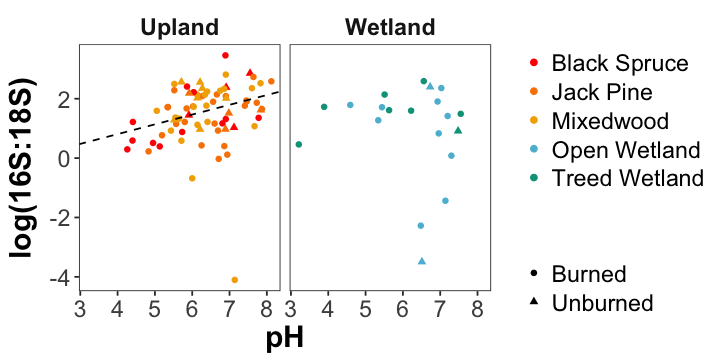

In [8]:
options(repr.plot.width=6, repr.plot.height=3)
p = ggplot(d,aes(x=pH,y=log(BF,10), color=Veg_Comm, shape=Burned_Unburned))
p = p + geom_point() + facet_grid(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("log(16S:18S)")
#p = p + geom_line(data=line,aes(x=pH,y=BF))

linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(0.329,NA), intercept=c(-0.5086,NA))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)

p

F = d%>%
    filter(Land_Class=="Upland")
#a = lm(log(F$BF,10)~log(F$TC_pct+1,10))
a = lm(log(F$BF,10)~F$pH)
summary(a)


Call:
lm(formula = log(F$BF, 10) ~ F$Understory_CBI)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1182 -0.4065  0.3283  0.9304  1.9343 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)        0.6240     0.5916   1.055    0.303
F$Understory_CBI   0.3771     0.5002   0.754    0.459

Residual standard error: 1.652 on 22 degrees of freedom
Multiple R-squared:  0.02518,	Adjusted R-squared:  -0.01913 
F-statistic: 0.5684 on 1 and 22 DF,  p-value: 0.4589


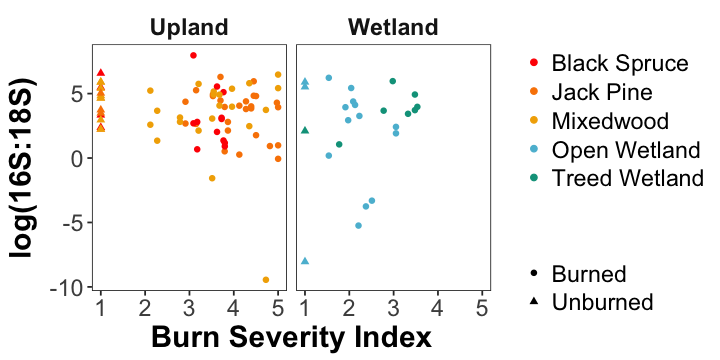

In [9]:
options(repr.plot.width=6, repr.plot.height=3)
p = ggplot(d,aes(x=Burn_Severity_Index,y=log(BF), color=Veg_Comm, shape=Burned_Unburned))
p = p + geom_point() + facet_wrap(~Land_Class)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + guides(color=guide_legend(title=""),shape=guide_legend(title=""))
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,strip.text.x = element_text(size=14, face="bold"),
        axis.title = element_text(size=18, face="bold"),
        axis.text = element_text(size=14),
        legend.text = element_text(size=14),
        legend.title = element_text(size = 18),
        strip.background = element_rect(colour="white", fill="white"))
p = p + ylab("log(16S:18S)") + xlab("Burn Severity Index")
p

F = d%>%
    filter(Land_Class=="Wetland")
a = lm(log(F$BF,10)~F$Understory_CBI)
summary(a)